In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sacc
import os

In [2]:
def make_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [3]:
dir = '../data_vectors/cosmodc2/2022/june6/'
#dir = '../data_vectors/cosmodc2/2022/feb11/'

file = 'analytic_noise/twopoint_data_fourier.sacc'
a = sacc.Sacc.load_fits(dir+file)
a_name = 'analytic'

file = 'twopoint_theory_fourier.sacc'
t = sacc.Sacc.load_fits(dir+file)
file = 'summary_statistics_fourier.sacc'
t_cov = sacc.Sacc.load_fits(dir+file)

file = 'summary_statistics_fourier_TJPCov.sacc'
t_covtjp = sacc.Sacc.load_fits(dir+file)

make_directory(dir + 'plots/')
for dt in a.get_data_types():
        print(dt)
print ('----')

W = "galaxy_density_xi"
GAMMA = "galaxy_shearDensity_xi_t"
GAMMAX = "galaxy_shearDensity_xi_x"
XIP = "galaxy_shear_xi_plus"
XIM = "galaxy_shear_xi_minus"
EE = "galaxy_shear_cl_ee"
DD = "galaxy_density_cl"
ED = "galaxy_shearDensity_cl_e"

galaxy_density_cl
galaxy_shearDensity_cl_b
galaxy_shearDensity_cl_e
galaxy_shear_cl_bb
galaxy_shear_cl_be
galaxy_shear_cl_eb
galaxy_shear_cl_ee
----


In [4]:
a.get_data_types()

['galaxy_density_cl',
 'galaxy_shearDensity_cl_b',
 'galaxy_shearDensity_cl_e',
 'galaxy_shear_cl_bb',
 'galaxy_shear_cl_be',
 'galaxy_shear_cl_eb',
 'galaxy_shear_cl_ee']

In [27]:
c = ["#474747", "#6992C2", "#C0E0FF", "#FADA77", "#FEB580", 'tomato', 'firebrick']
zs = [0.19285902, 0.40831394, 0.65503818, 0.94499109, 1.2947086, 1.72779632, 2.27855242, 3. ] 
nsbins = len(zs)-1
def convert_to_z_labels(z):
    return ['$%0.2f < z < %0.2f$'%(z[i], z[i+1]) for i in range(len(z)-1)]
zs_labels = convert_to_z_labels(zs)
print(zs_labels)

nside = 2048
# Lens sample
#bias_sheth = [1.4898, 1.5476, 1.7716, 1.9811, 2.1756] # using interpolated cosmodc2 + sheth01 for the bias
#bias_bhat = [1.2736598368851615, 1.3098155824414275, 1.4893638276960628, 1.668048563010521,1.8370479233940058] # using interpolated cosmodc2 + Bhattacharya11 for the bias
#bias_tink = [1.404105583793727,1.4582420469437034,1.6931109537810722,1.921839383230561,2.1327663184325547]
bias = [1.404105583793727,1.4582420469437034,1.6931109537810722,1.921839383230561,2.1327663184325547]
zl = [0.15, 0.3, 0.45, 0.6, 0.75, 0.9]
nlbins = len(zl)-1
zl_labels = convert_to_z_labels(zl)
print(zl_labels)

['$0.19 < z < 0.41$', '$0.41 < z < 0.66$', '$0.66 < z < 0.94$', '$0.94 < z < 1.29$', '$1.29 < z < 1.73$', '$1.73 < z < 2.28$', '$2.28 < z < 3.00$']
['$0.15 < z < 0.30$', '$0.30 < z < 0.45$', '$0.45 < z < 0.60$', '$0.60 < z < 0.75$', '$0.75 < z < 0.90$']


In [6]:
def get_mean(s, dt, factor, lmax):
    dps = s.get_data_points(dt)
    mean = []
    thetas = []
    masks = []
    for dp in dps:
        if dp['ell']<lmax:
            
            if dt == ED:
                source_bin = int(dp.tracers[0][-1])
                lens_bin = int(dp.tracers[1][-1])
                bias_i = factor[lens_bin]
                mean.append(dp.value*bias_i)
                mask = True

            if dt == DD:
                lens_bin1 = int(dp.tracers[0][-1])
                lens_bin2 = int(dp.tracers[1][-1])
                if lens_bin1==lens_bin2:
                    bias_1 = factor[lens_bin1]
                    bias_2 = factor[lens_bin2]
                    mean.append(dp.value*bias_1*bias_2)
                    mask = True
                else:
                    mask = False
            if dt == EE:
                mean.append(dp.value)
                mask = True
            
        else:
            mask = False
            
        masks.append(mask)
    mean = np.array(mean)
    masks = np.array(masks)
    return mean, masks


def get_theta(s, dt):
    dps = s.get_data_points(dt)
    thetas = []
    for dp in dps:
        thetas.append(dp['ell'])
    thetas = np.array(thetas)
    return thetas

def get_cov(s, dt):
    ind = s.indices(dt)
    cov = s.covariance.get_block(ind)
    return cov  
    
    
def compute_chi2_gauss(data, theory, cov_th, dt, factor = np.ones(nlbins), lmax=2*nside):
    print('Cutting scales larger than', lmax)
    theory_mean, mask = get_mean(theory, dt, factor = factor, lmax=lmax)
    data_mean, mask = get_mean(data, dt, factor=np.ones(nlbins), lmax=lmax)

    cov = get_cov(cov_th, dt)
    cov = (cov[mask]).T[mask]
    invcov = np.linalg.inv(cov) 
    
    deltachi2 = np.dot(np.dot(data_mean-theory_mean, invcov), data_mean-theory_mean)
    ndf = len(data_mean)
    
    return deltachi2, ndf, cov


def compute_chi2_jk(data, theory, dt):
    data_mean = get_mean(data, dt)
    theory_mean = get_mean(theory, dt)
    
    cov = get_cov(data, dt)
    invcov = np.linalg.inv(cov)
    deltachi2 = np.dot(np.dot(data_mean-theory_mean, invcov), data_mean-theory_mean)
    ndf = len(data_mean)
    
    return deltachi2, ndf, cov

def compute_chi2_jk_null(data, dt):
    data_mean = get_mean(data, dt)
    
    cov = get_cov(data, dt)
    invcov = np.linalg.inv(cov)
    deltachi2 = np.dot(np.dot(data_mean, invcov), data_mean)
    ndf = len(data_mean)
    
    return deltachi2, ndf, cov


## Compare theory with measurements

In [43]:
print('With TXFourierGaussianCovariance')
# get chi2s
deltachi2, ndf, cov = compute_chi2_gauss(a, t, cov_th = t_cov, dt =EE, lmax = 1.5*nside)
print('delta chi2/ndf shear cl = %0.1f/%d = %0.1f'%(deltachi2, ndf, deltachi2/ndf))

deltachi2, ndf, cov = compute_chi2_gauss(a, t,cov_th = t_cov, dt =ED, factor = bias, lmax = 200)
print('delta chi2/ndf galaxy-shear cl  =%0.1f/%d = %0.1f'%(deltachi2, ndf, deltachi2/ndf))
#print('delta chi2/ndf galaxy-shear cl (Sims cov, only z_lens < z_source)) = %0.1f/%d'%(deltachi2sims, ndf))
# only auto
deltachi2, ndf, cov = compute_chi2_gauss(a, t, cov_th = t_cov, dt =DD, factor = bias, lmax = 200)
print('delta chi2/ndf galaxy cl (only auto correlations) = %0.1f/%d = %0.1f'%(deltachi2, ndf, deltachi2/ndf))
#print('delta chi2/ndf galaxy cl (Sims cov, only auto correlations) = %0.1f/%d'%(deltachi2sims, ndf))

With TXFourierGaussianCovariance
Cutting scales larger than 3072.0
delta chi2/ndf shear cl = 951.1/672 = 1.4
Cutting scales larger than 200
delta chi2/ndf galaxy-shear cl  =284.6/175 = 1.6
Cutting scales larger than 200
delta chi2/ndf galaxy cl (only auto correlations) = 76.0/25 = 3.0


In [47]:
print('With TJPCov')
# get chi2s
deltachi2, ndf, cov = compute_chi2_gauss(a, t, cov_th = t_covtjp, dt =EE, lmax = 1.5*nside)
print('delta chi2/ndf shear cl = %0.1f/%d = %0.1f'%(deltachi2, ndf, deltachi2/ndf))

deltachi2, ndf, cov = compute_chi2_gauss(a, t,cov_th = t_covtjp, dt =ED, factor = bias, lmax = 500)
print('delta chi2/ndf galaxy-shear cl  =%0.1f/%d = %0.1f'%(deltachi2, ndf, deltachi2/ndf))
#print('delta chi2/ndf galaxy-shear cl (Sims cov, only z_lens < z_source)) = %0.1f/%d'%(deltachi2sims, ndf))
# only auto
deltachi2, ndf, cov = compute_chi2_gauss(a, t, cov_th = t_covtjp, dt =DD, factor = bias, lmax = 500)
print('delta chi2/ndf galaxy cl (only auto correlations) = %0.1f/%d = %0.1f'%(deltachi2, ndf, deltachi2/ndf))
#print('delta chi2/ndf galaxy cl (Sims cov, only auto correlations) = %0.1f/%d'%(deltachi2sims, ndf))

With TJPCov
Cutting scales larger than 3072.0
delta chi2/ndf shear cl = 760.3/672 = 1.1
Cutting scales larger than 500
delta chi2/ndf galaxy-shear cl  =473.4/385 = 1.2
Cutting scales larger than 500
delta chi2/ndf galaxy cl (only auto correlations) = 492.7/55 = 9.0


### Previous version Feb 11

In [8]:
print('With TXFourierGaussianCovariance')
# get chi2s
deltachi2, ndf, cov = compute_chi2_gauss(a, t, cov_th = t_cov, dt =EE, lmax = 1.5*nside)
print('delta chi2/ndf shear cl = %0.1f/%d = %0.1f'%(deltachi2, ndf, deltachi2/ndf))

deltachi2, ndf, cov = compute_chi2_gauss(a, t,cov_th = t_cov, dt =ED, factor = bias, lmax = 0.25*nside)
print('delta chi2/ndf galaxy-shear cl  = %0.1f/%d = %0.1f'%(deltachi2, ndf, deltachi2/ndf))
#print('delta chi2/ndf galaxy-shear cl (Sims cov, only z_lens < z_source)) = %0.1f/%d'%(deltachi2sims, ndf))
# only auto
deltachi2, ndf, cov = compute_chi2_gauss(a, t, cov_th = t_cov, dt =DD, factor = bias, lmax = 0.25*nside)
print('delta chi2/ndf galaxy cl (only auto correlations) = %0.1f/%d = %0.1f'%(deltachi2, ndf, deltachi2/ndf))
#print('delta chi2/ndf galaxy cl (Sims cov, only auto correlations) = %0.1f/%d'%(deltachi2sims, ndf))

With TXFourierGaussianCovariance
Cutting scales larger than 3072.0
delta chi2/ndf shear cl = 668.3/532 = 1.3
Cutting scales larger than 512.0
delta chi2/ndf galaxy-shear cl  = 516.2/315 = 1.6
Cutting scales larger than 512.0
delta chi2/ndf galaxy cl (only auto correlations) = 608.0/45 = 13.5


# Make plots of the measurements and theory

In [32]:
def plot_twopoint(s, theory=None, theory_cov = None, datatype=None, ratios = False, diff = False, diff_with_errors=False):

        
    for dt in s.get_data_types():
        
        if dt == EE:
            nbins1 = nsbins
            nbins2 = nsbins
            name1 = 'source'
            name2 = 'source'
        
        if dt == ED:
            nbins1 = nsbins
            nbins2 = nlbins
            name1 = 'source'
            name2 = 'lens'

        if dt == DD:
            nbins1 = nlbins
            nbins2 = nlbins
            name1 = 'lens'
            name2 = 'lens'
            
        if dt == datatype:
            print(dt)
            plt.clf()
            if dt == ED:
                fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 3.2*nbins2), sharey=True, sharex=True)
            else:
                fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 2.2*nbins2), sharey=True, sharex=True)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)

            for i in range(nbins1):
                for j in range(nbins2):

                    ell, cl = s.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j))

                        
                    if theory_cov is not None:
                        # this returns the theory cov, and overwrites the error if theory_cov is not None
                        _, _, cov = theory_cov.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                        err = np.sqrt(np.diag(cov))
                    
                    if theory is not None:
                        ell_th, cl_th = theory.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = False)
                        #print(ell, cl_th)
                        
                    if datatype == ED:
                        cl_th_bias = cl_th*bias[j]
                    if datatype == DD:
                        cl_th_bias = cl_th*bias[j]*bias[i]
                    if datatype == EE:
                        cl_th_bias = cl_th
                        
                    if ratios:
                        ax[i][j].errorbar(ell, cl/cl_th_bias, err/cl_th, fmt = '.',  capsize=1.5, elinewidth=0.8, color = c[1], label = 'Measurement/Theory')
                    elif diff:
                        ax[i][j].errorbar(ell, cl-cl_th, fmt = '.',  capsize=1.5, elinewidth=0.8, color = c[1], label = 'Measurement-Theory')
                        ax[i][j].fill_between(theta, -err, err, alpha = 0.5, color = 'powderblue')
       
                    if datatype == EE:
                        ax[i][j].plot(ell_th, cl_th, ls = '-', lw = '1.5', color = c[1], label = 'Theory')
                        ax[i][j].errorbar(ell, cl, err, fmt = '.', capsize=1.5, elinewidth=0.8, color = c[1], label = 'Measurements')
                    
                    
                    if datatype == ED or DD:
         
                        ax[i][j].plot(ell, cl_th_bias, ls = '-', lw = '1.5', color = c[1], label = 'Theory ($b$ from Tinker)') 
                        ax[i][j].plot(ell, cl_th, ls = '-', lw = '1.5', color = 'lightgray', label = 'Theory ($b=1$)')
                        ax[i][j].errorbar(ell, cl, err, fmt = '.', capsize=1.5, elinewidth=0.8, color = c[1], label = 'Measurements')
                            
                    if (datatype==EE) or ((datatype==DD or datatype==ED) and j>0 or i>0):
                        ax[i][j].text(0.5, 0.88, "(%d, %d)"%(i+1, j+1), horizontalalignment='center',
                                  verticalalignment='center', transform=ax[i][j].transAxes)#, fontsize=12)
                        
                    ax[i][j].set_xscale('log')
                    ax[i][j].set_xlim(100, 2*nside)
                    

                    if ratios:
                        ax[i][j].set_ylim(0.6, 1.4)
                        ax[i][j].axhline(y =1, ls = ':', color = 'k')
                    elif diff:
                        ax[i][j].set_ylim(-0.00001, 0.000005)
                        ax[i][j].axhline(y =0, ls = ':', color = 'k')
                    elif diff_with_errors:
                        ax[i][j].set_ylim(-3, 3.)
                        ax[i][j].axhline(y =0, ls = ':', color = 'k')
                    else:
                        ax[i][j].set_yscale('log')
                        if datatype==EE:
                            ax[i][j].set_ylim(8*10**(-12), 10**(-7))
                        #if datatype==ED:
                        #    ax[i][j].set_ylim(2*10**(-9), 3.5*10**(-4))  
                        #if datatype==GAMMA:

                    if i==nbins1-1: 
                        ax[i][j].set_xlabel(r'$\ell$')
                
                    if j==0:
                        if datatype==EE:
                            ax[i][j].set_ylabel(r'$C_{\gamma \gamma}(\ell)$')
                        if datatype==ED:
                            ax[i][j].set_ylabel(r'$C_{\delta \gamma}(\ell)$')
                        if datatype==DD:
                            ax[i][j].set_ylabel(r'$C_{\delta \delta}(\ell)$')

                            
                    if datatype!=ED:
                        if i<j:
                            fig.delaxes(ax[i, j])
    if datatype==ED or datatype==DD:
        ax[0][0].legend(frameon = False, loc = 'best')

    return fig


In [10]:
def arcmin2_to_rad2(density):
    return density*60**2*41253/(4*np.pi)

def plot_noise(s, datatype=None, compare=None, density_arcmin=None):
    plt.rc("text", usetex=True)
    plt.rc("font", family="serif")
        
    for dt in s.get_data_types():
        
        if dt == EE:
            nbins1 = nsbins
            nbins2 = nsbins
            name1 = 'source'
            name2 = 'source'
        
        if dt == ED:
            nbins1 = nsbins
            nbins2 = nlbins
            name1 = 'source'
            name2 = 'lens'

        if dt == DD:
            nbins1 = nlbins
            nbins2 = nlbins
            name1 = 'lens'
            name2 = 'lens'
            
        if dt == datatype:
            print(dt)
            plt.clf()
            # noise is 0 for cross-correlations, only matters for auto redshift bins
            fig, ax = plt.subplots(1, nbins1, figsize=(1.8*nsbins, 1.8*0.95), sharey=True, sharex=True)

            plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
            for i in range(nbins1):
                    ell, cl = s.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, i))
                    n_ell = s.get_tag( 'n_ell', data_type=dt, tracers=('%s_%s'%(name1,i),'%s_%s'%(name2, i)) )
                    n_ell_coupled = s.tracers['%s_%s'%(name1,i)].metadata['n_ell_coupled']
                    if compare is not None:
                        n_ell_analytic = compare.get_tag( 'n_ell', data_type=dt, tracers=('%s_%s'%(name1,i),'%s_%s'%(name2, i)) )
                        n_ell_coupled_analytic = compare.tracers['%s_%s'%(name1,i)].metadata['n_ell_coupled']
                    if n_ell is not None:
                        ax[i].plot(ell, np.array(n_ell), ls = '-', lw = '1.5', color = c[1], label = 'From maps')
                        ax[i].plot(ell, n_ell_analytic, ls = '--', lw = '1.5', color = c[1], label = 'Analytic')
                        ax[i].plot(ell, [n_ell_coupled]*len(ell), ls = '-', lw = '1.5', color = c[4], label = 'From maps coupled')
                        ax[i].plot(ell, [n_ell_coupled_analytic]*len(ell), ls = '--', lw = '1.5', color = c[4], label = 'Analytic coupled')

                    if density_arcmin is not None:
                        density_rad = arcmin2_to_rad2(density_arcmin[i])
                        noise_direct = 1/density_rad
                        ax[i].plot(ell, [noise_direct]*len(ell), ls = ':', lw = '1.5', color = c[0], label = '1/ndens')
                    
                    ax[i].set_xscale('log')
                    ax[i].set_yscale('log')
                
                    ax[i].set_xlabel(r'$\ell$')
                
    
                    if dt == DD:
                        ax[0].set_ylabel(r'Clustering Noise')
                    if dt == EE:
                        ax[0].set_ylabel(r'Cosmic shear Noise')


    ax[0].legend(frameon = False,bbox_to_anchor = (6.9, 0.94))

    return fig


galaxy_density_cl


<Figure size 432x288 with 0 Axes>

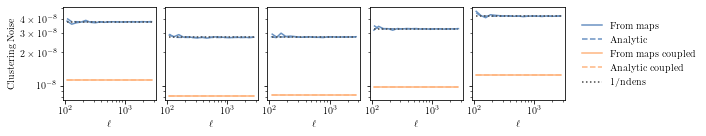

In [13]:
lens_density = np.array([0.018115458448473835, 0.0348763018449613, 0.05980260363102459, 0.0890867121108154, 0.1072563048039318])
fig = plot_noise(d, datatype=DD, compare=a, density_arcmin = lens_density)
make_directory(dir + 'plots/noise/')
plt.savefig(dir + 'plots/noise/' + 'cl_galaxy_noise.png', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shear_cl_ee


<Figure size 432x288 with 0 Axes>

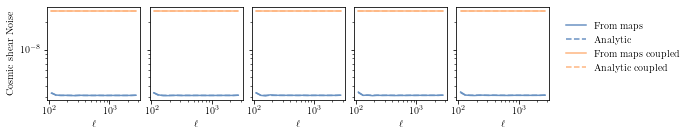

In [14]:
fig = plot_noise(d, datatype=EE, compare=a)
make_directory(dir + 'plots/noise/')
plt.savefig(dir + 'plots/noise/' + 'cl_shear_noise.png', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)


galaxy_shear_cl_ee


/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/sacc/sacc.py:370: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


<Figure size 432x288 with 0 Axes>

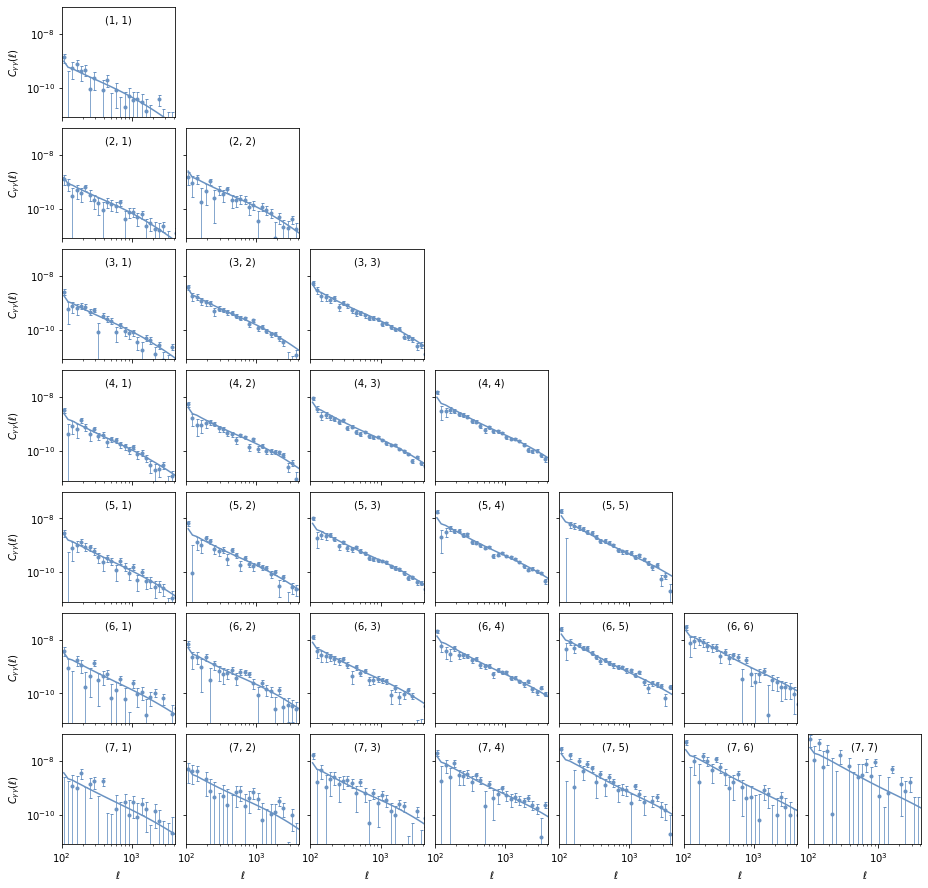

In [15]:
fig = plot_twopoint(a, theory=t, theory_cov = t_cov, datatype=EE, ratios = False, diff = False, diff_with_errors = False)
plt.savefig(dir + 'plots/' + 'cl_shear_%s'%a_name, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shear_cl_ee


<Figure size 432x288 with 0 Axes>

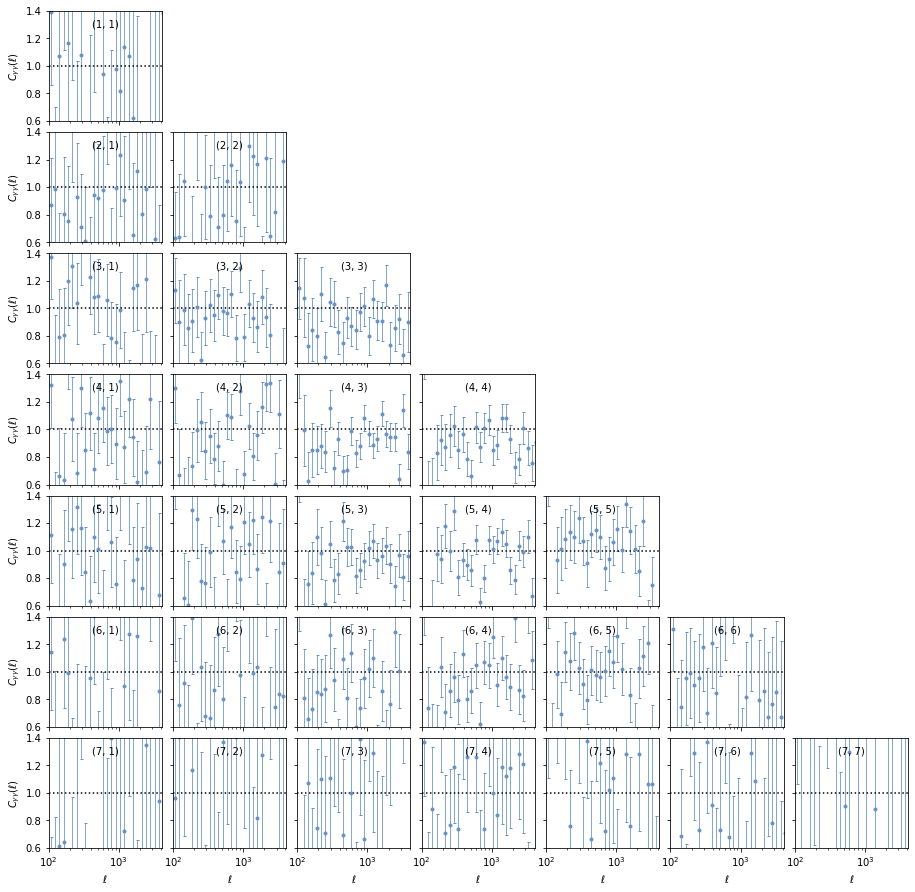

In [26]:
fig = plot_twopoint(a, theory=t, theory_cov = t_cov, datatype=EE, ratios = True, diff = False, diff_with_errors = False)
plt.savefig(dir + 'plots/' + 'cl_shear_%s_ratios'%a_name, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shearDensity_cl_e


<Figure size 432x288 with 0 Axes>

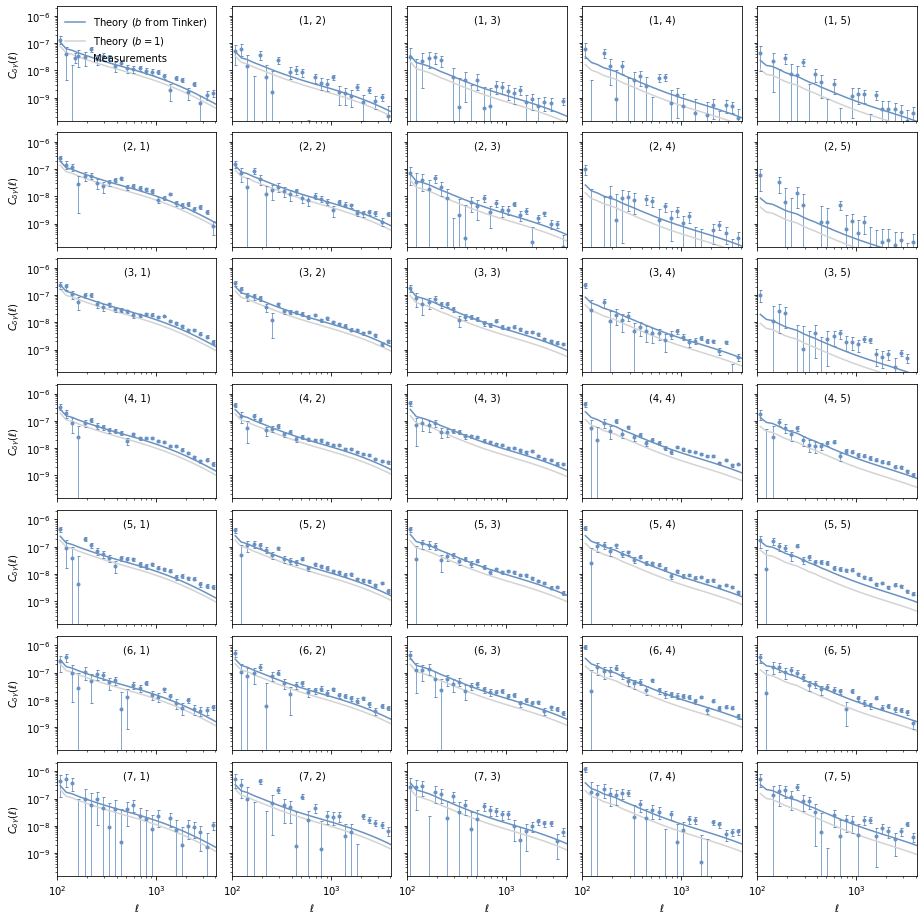

In [33]:
fig = plot_twopoint(a, theory=t, theory_cov = t_cov, datatype=ED, ratios = False, diff = False, diff_with_errors = False)
plt.savefig(dir + 'plots/' + 'cl_galaxyshear_%s'%a_name, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shearDensity_cl_e


<Figure size 432x288 with 0 Axes>

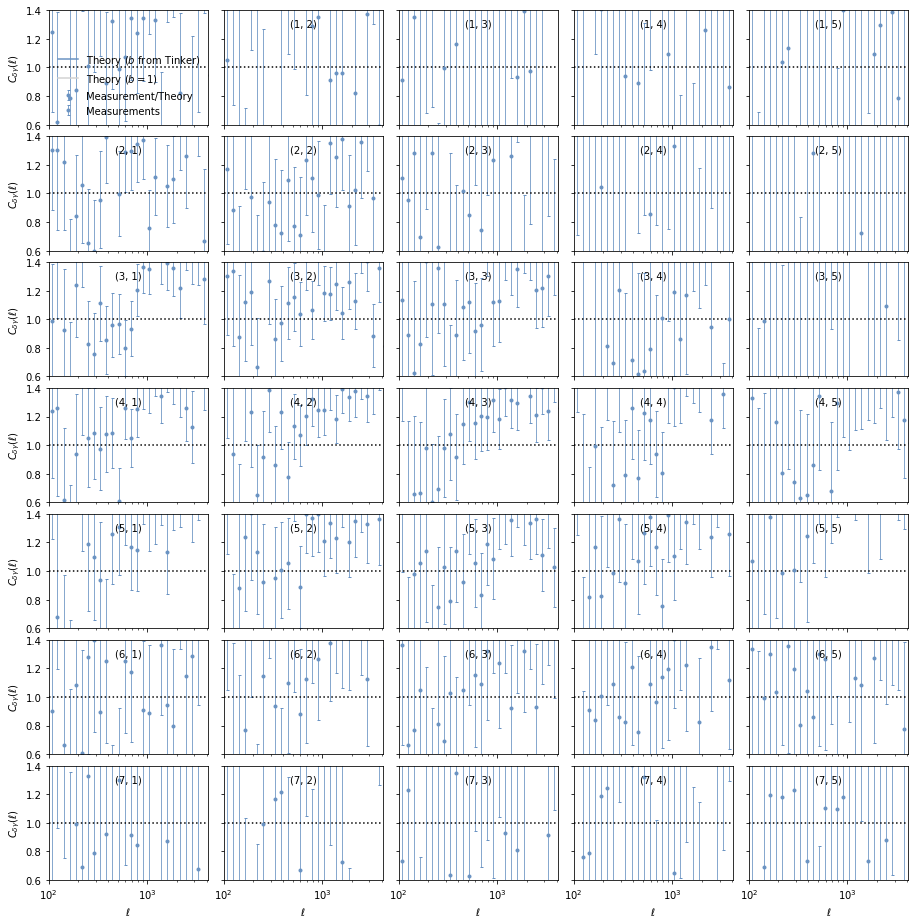

In [34]:
fig = plot_twopoint(a, theory=t, theory_cov = t_cov, datatype=ED, ratios = True, diff = False, diff_with_errors = False)
plt.savefig(dir + 'plots/' + 'cl_galaxyshear_%s_ratios'%a_name, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_density_cl


<Figure size 432x288 with 0 Axes>

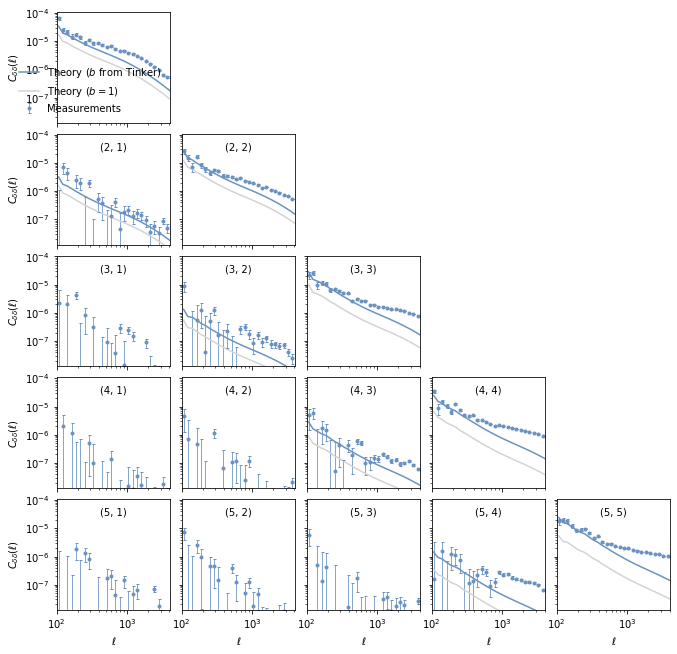

In [19]:
fig = plot_twopoint(a, theory=t, theory_cov = t_cov, datatype=DD, ratios = False, diff = False, diff_with_errors = False)
plt.savefig(dir + 'plots/' + 'cl_galaxy_%s'%a_name, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_density_cl


/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide


<Figure size 432x288 with 0 Axes>

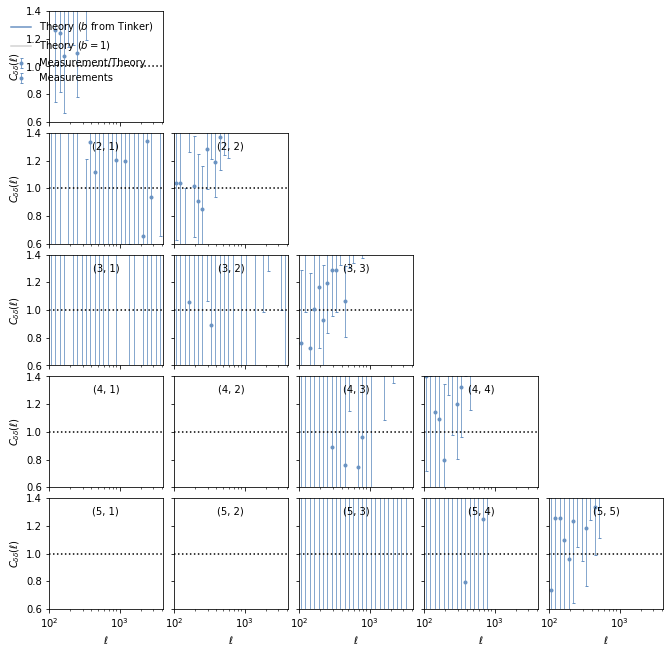

In [35]:
fig = plot_twopoint(a, theory=t, theory_cov = t_cov, datatype=DD, ratios = True, diff = False, diff_with_errors = False)
plt.savefig(dir + 'plots/' + 'cl_galaxy_%s_ratios'%a_name, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

In [50]:
def corrmatrix(cov):
    cov = np.mat(cov)
    D = np.diag(np.sqrt(np.diag(cov)))
    d = np.linalg.inv(D)
    corr = d*cov*d
    return corr

def plot_cov(cov, size):
    
    ncov1 = len(cov)
    ncov2 = len(cov[0])
    
    corr = corrmatrix(cov)
    cov_vmin = np.min(corr)
    
    figsize1 = 1.22222222227*ncov1/size
    figsize2 = ncov2/size
    fig, ax = plt.subplots(1, 1, figsize=(figsize1, figsize2))
    im = ax.imshow(corr, interpolation='nearest',
                           aspect='auto', origin='lower', vmin=-0.5, vmax=1.)
    cbar = fig.colorbar(im)
    return fig

In [32]:
def plot_errorbars(s, theory_cov = None, theory_cov2 = None, datatype=None, ratios = False):
      
    for dt in s.get_data_types():
        
        
        if dt == EE:
            nbins1 = nsbins
            nbins2 = nsbins
            name1 = 'source'
            name2 = 'source'
        
        if dt == ED:
            nbins1 = nsbins
            nbins2 = nlbins
            name1 = 'source'
            name2 = 'lens'

        if dt == DD:
            nbins1 = nlbins
            nbins2 = nlbins
            name1 = 'lens'
            name2 = 'lens'
            
        if dt == datatype:
            print(dt)
            plt.clf()

            fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 2.2*nbins2), sharey=True, sharex=True)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)

            for i in range(nbins1):
                for j in range(nbins2):
                        
                    ell, _, cov_th = theory_cov.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                    err_th = np.sqrt(np.diag(cov_th))
                        
                    _, _, cov_th2 = theory_cov2.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                    err_th2 = np.sqrt(np.diag(cov_th2))                       
                        

                    if ratios:
                        ax[i][j].plot(ell, err_th2/err_th, lw = 2,ls = '-', color = c[1], label = 'Mask effects/$f_{\mathrm{sky}}$')
                    else:
                        ax[i][j].plot(ell, err_th, lw = 2, color = c[0], label = '$f_{\mathrm{sky}}$')
                        
                        ax[i][j].plot(ell, err_th2, lw = 2,color = c[1],  label = 'Mask effects')  

                    ax[i][j].text(0.5, 0.88, "(%d, %d)"%(i+1, j+1), horizontalalignment='center',
                                  verticalalignment='center', transform=ax[i][j].transAxes)#, fontsize=12)
                    ax[i][j].set_xscale('log')
                    ax[i][j].set_xlim(100, 2*nside)
                    
                    if ratios:
                        #ax[i][j].set_ylim(0.9, 1.4)
                        ax[i][j].axhline(y =1, ls = ':', color = 'k')

                    else:
                        ax[i][j].set_yscale('log')
                        #if datatype==EE:
                        #    ax[i][j].set_ylim(8*10**(-12), 10**(-7))
                        #if datatype==ED:
                        #    ax[i][j].set_ylim(2*10**(-9), 3.5*10**(-4))  
                        #if datatype==GAMMA:

                    if i==nbins1-1: 
                        ax[i][j].set_xlabel(r'$\ell$')
                
                    if j==0:
                        if datatype==EE:
                            ax[i][j].set_ylabel(r'$\sigma(C_{\gamma \gamma})$')
                        if datatype==ED:
                            ax[i][j].set_ylabel(r'$\sigma(C_{\delta \gamma})$')
                        if datatype==DD:
                            ax[i][j].set_ylabel(r'$\sigma(C_{\delta \delta})$')

                             
                    if datatype!=GAMMA:
                        if i<j:
                            fig.delaxes(ax[i, j])

    ax[0][0].legend(frameon = True, loc = 'lower left', fontsize = 10)

    return fig


In [ ]:
fig = plot_errorbars(a, theory_cov = t_cov, theory_cov2 = t_covtjp, datatype=EE, ratios = False)
plt.savefig(dir + 'plots/' + 'cl_shear_errors', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

In [ ]:
fig = plot_errorbars(a, theory_cov = t_cov, theory_cov2 = t_covtjp, datatype=ED, ratios = False)
plt.savefig(dir + 'plots/' + 'cl_galaxyshear_errors', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

In [ ]:
fig = plot_errorbars(a, theory_cov = t_cov, theory_cov2 = t_covtjp, datatype=DD, ratios = False)
plt.savefig(dir + 'plots/' + 'cl_galaxy_errors', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shear_cl_ee


<Figure size 432x288 with 0 Axes>

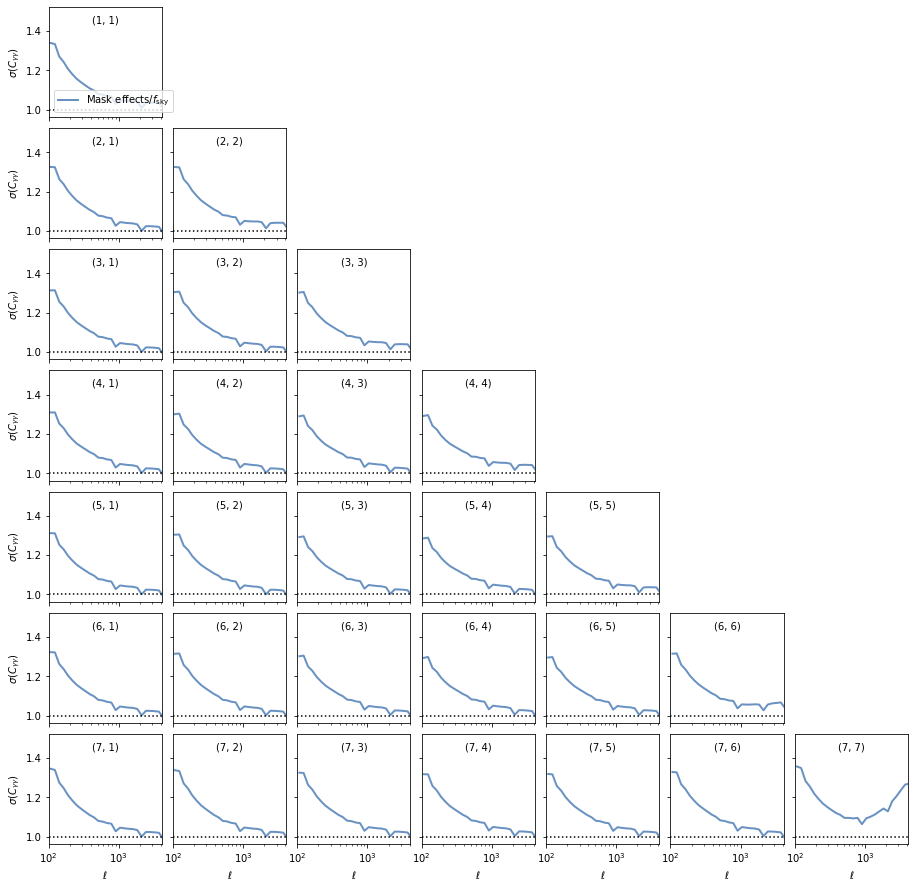

In [37]:
fig = plot_errorbars(a, theory_cov = t_cov, theory_cov2 = t_covtjp, datatype=EE, ratios = True)
plt.savefig(dir + 'plots/' + 'cl_shear_errors_ratios', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shearDensity_cl_e


<Figure size 432x288 with 0 Axes>

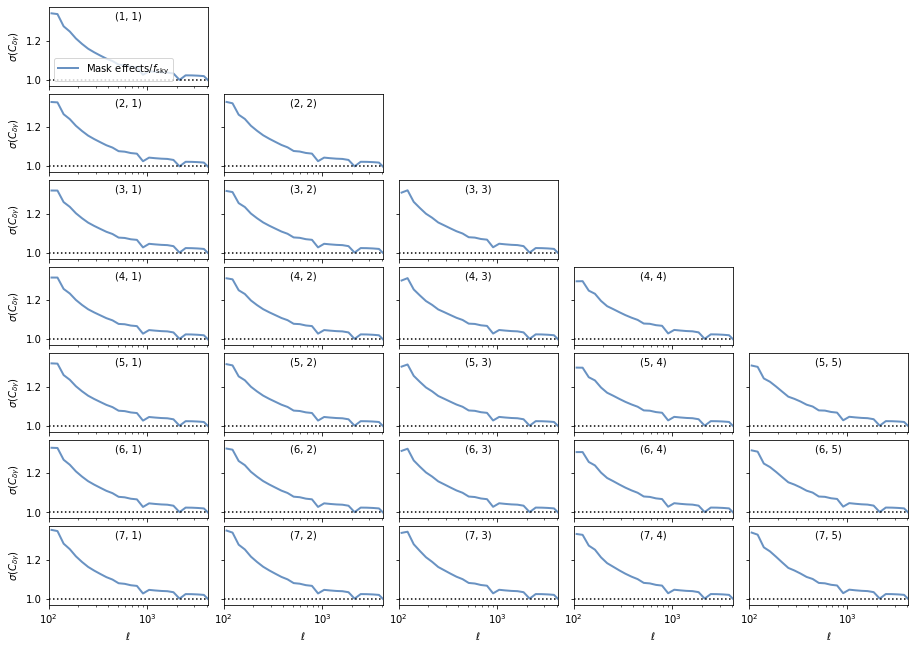

In [38]:
fig = plot_errorbars(a, theory_cov = t_cov, theory_cov2 = t_covtjp, datatype=ED, ratios = True)
plt.savefig(dir + 'plots/' + 'cl_galaxyshear_errors_ratios', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_density_cl


<Figure size 432x288 with 0 Axes>

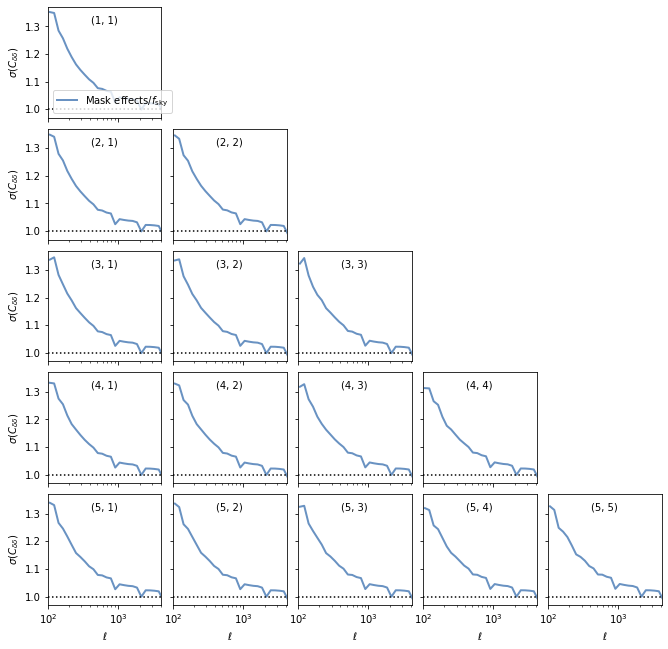

In [39]:
fig = plot_errorbars(a, theory_cov = t_cov, theory_cov2 = t_covtjp, datatype=DD, ratios = True)
plt.savefig(dir + 'plots/' + 'cl_galaxy_errors_ratios', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)